# Wheelchair Control

![](images/wheelchair.jpg)

### Python Dependencies

In [1]:
from numpy import *
from numpy.linalg import *

from scipy.linalg import *
from scipy.integrate import *
from scipy.signal import *

from matplotlib.pyplot import *

Step 1 - Wheelchair Planar Model
================================

### Introduction

We consider a simple model of a wheelchair evolving in the plane. It is mainly made of

  - A frame ; from above, its most visible component is the seat. We assume that it is a square,

  - Two fixed wheels (their orientation with respect to the frame does not change). 
    They are parallel and located at opposite ends of the seat. 
    
We assume that the seat backrest is on top of the wheels common axis.


Let $(0, e_x, e_y)$ be a direct orthonormal frame of the plane. We denote 

  - $(x, y)$ the coordinates of the wheel axis center in the orthonormal and 
  - $\theta$ the angle of the wheels direction with respect to vector $e_x$ ; with $\theta = 0$ when the front of the wheelchait faces the right ($e_x$) and $\theta = \pi/2$ when it faces upwards ($e_y$).

  - $\phi_l$ and $\phi_r$ the rotation angles of the left and right wheel respectively ; by convention, when these angles increase, the wheelchair moves forward.

### Parameter Definition

From now on, we assume that the seat side length is $L = 50 \mbox{ cm}$ and the wheel radius is $R_w = 30 \mbox{ cm}$.

🧩 Define the corresponding Python variables `L` and `Rw` (express every length in meters, and more generally in the sequel, always use the [international standard of units](https://en.wikipedia.org/wiki/SI_derived_unit)) for numerical values. 

In [2]:
# 🔓
L = 50 / 100
Rw = 30 / 100

### Graphical Representation

🧩 Implement a function `draw_wheelchair` with arguments `x`, `y` and `theta` that draws a simple geometric model of the wheelchair (with seat and fixed wheels) in the plane (top view) for arbitrary values of $(x, y)$ and $\theta$. 

🗝️ **Hint.** Use the function `plot` of `matplotlib.pyplot`.

In [3]:
# 🔓
def draw_wheelchair(x, y, theta):
    translation = array([[x], [y]])
    rotation = array([
        [cos(theta), -sin(theta)], 
        [sin(theta),  cos(theta)]
    ])

    # Seat
    corners = [[0, -L/2], [L, -L/2], [L, +L/2], [0, L/2]]
    corners += [corners[0]]
    corners = array(corners).T
    corners = rotation @ corners + translation
    xc = corners[0]
    yc = corners[1]
    fill(xc, yc, color="#868e96", zorder=10)
    
    # Fixed Wheels
    wheel_left_xy_start = rotation @ [[-Rw], [-L/2]] + translation 
    wheel_left_xy_end = rotation @ [[Rw], [-L/2]] + translation
    plot([wheel_left_xy_start[0], wheel_left_xy_end[0]], [wheel_left_xy_start[1], wheel_left_xy_end[1]], color="black",linewidth=5, zorder=20)

    wheel_right_xy_start = rotation @ [[-Rw], [+L/2]] + translation
    wheel_right_xy_end = rotation @ [[Rw], [L/2]] + translation
    plot([wheel_right_xy_start[0], wheel_right_xy_end[0]], [wheel_right_xy_start[1], wheel_right_xy_end[1]], color="black", linewidth=5, zorder=20)
    

🧩 Represent the wheelchair when $(x, y, \theta) = (0, 0, 0), (2, 2, \pi/2), (0, 4, \pi), (-2, 2, 3\pi/2)$.

🗝️ **Hint.** Use the following `draw_arena` function beforehand.

In [4]:
def draw_arena(xmin, xmax, ymin, ymax):
    wh_ratio = (xmax - xmin) / (ymax - ymin)
    figsize = fig_width, fig_height = 16, 16 / wh_ratio
    figure(figsize=figsize)
    axes = gca()
    axes.axis([xmin, xmax, ymin, ymax])
    axes.set_aspect(1)
    xticks(arange(xmin, xmax+1, 1))
    yticks(arange(ymin, ymax+1, 1))
    grid(True)

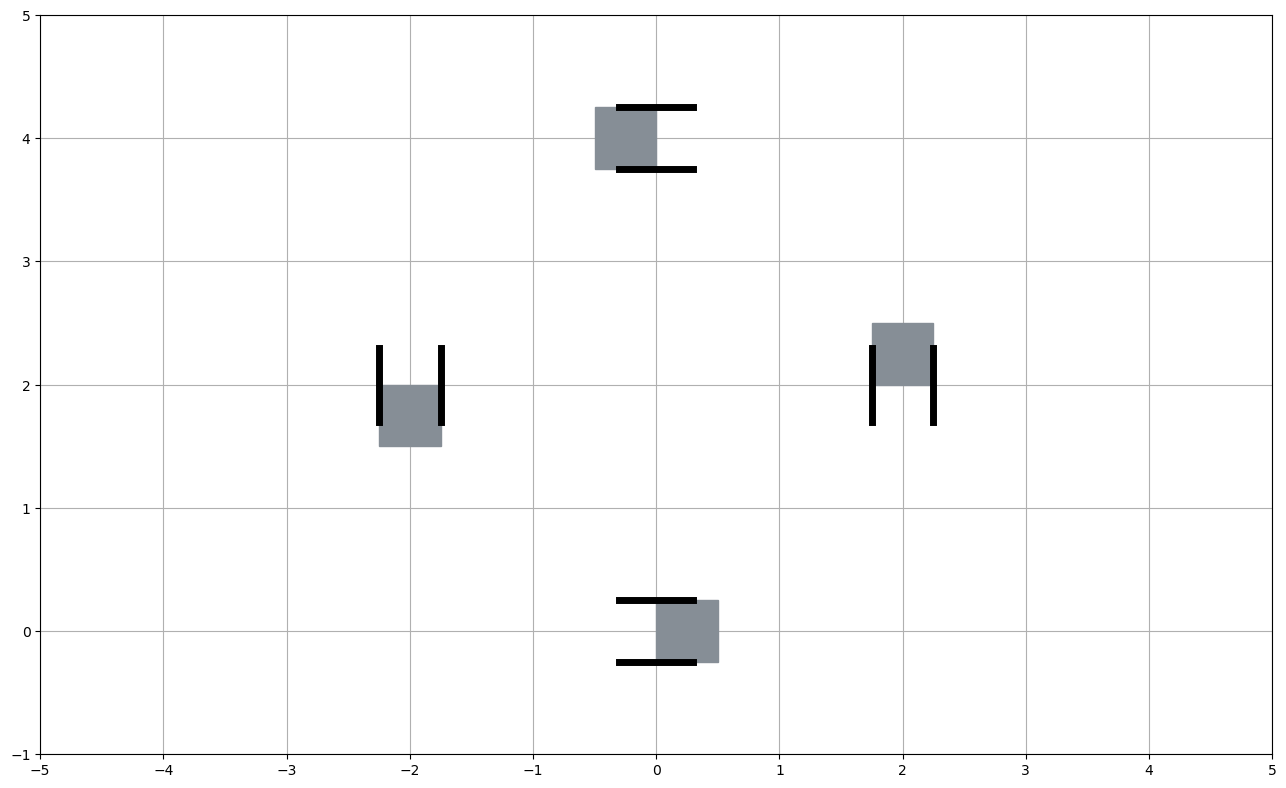

In [5]:
# 🔓
draw_arena(-5, 5, -1, 5)
draw_wheelchair(0, 0, 0)
draw_wheelchair(2, 2, pi/2)
draw_wheelchair(0, 4, pi)
draw_wheelchair(-2, 2, 3*pi/2)

### Kinematic Modeling

We assume that we can control the wheels angular velocities $\omega_l = \dot{\phi}_l$ and $\omega_r = \dot{\phi}_r$ (this is a *kinematic* model of the wheelchair).
We also assume that the wheelchair fixed wheels roll without slipping. 

🧩 Establish the differential equations that relate $\dot{x}$,
$\dot{y}$ and $\dot{\theta}$ with $\omega_l$ and $\omega_r$.

🔓
$$
\begin{array}{rcl}
\dot{x} &=& R_w  \frac{\omega_l + \omega_r}{2} \cos \theta \\
\dot{y} &=& R_w  \frac{\omega_l + \omega_r}{2} \sin \theta \\
\dot{\theta} &=& R_w  \frac{\omega_r - \omega_l}{L} \\
\end{array}
$$

### Analysis

🧩 Show that if $\omega_l$ and $\omega_r$ are continuously differentiable functions of $(x, y, \theta)$ (which includes the case of constant inputs), this system is well-posed.

🔓 The vector field is continuously differentiable as a composition of continuously differentiable functions, thus the IVP is well-posed.

🧩 Show that if $\omega_l$ and $\omega_r$ are constants, the maximal solution associated to any initial state is global. Is is still true of $\omega_l$ and $\omega_r$ are arbitrary continuously differentiable functions of $(x, y, \theta)$ ?

🔓 When the inputs are constant, it's pretty easy to prove that the derivatives of $x$, $y$ and $\theta$ with respect to $t$ are uniformly bounded ; thus $x$, $y$ and $\theta$ are bounded on any bounded time interval and therefore no finite-time blowup may happen: the maximal solution is global.

The situation is different with state-dependent inputs; for example with $\omega_r = - \omega_l = 0.5 (L/R_w)  \theta^2$, we end up with $\dot{\theta}(t) = \theta(t)^2$ which has a finite-time blowup for some initial values of $\theta$. Thus, the maximal solution may not be global.

### Vector Field

In the sequel, `omega` is a function that computes the input vector $\omega := (\omega_l, \omega_r)$ given the time $t$ and $(x, y, \theta)$ (thus, it may depend on the time and/or on the system state if needed). For example:

In [6]:
def omega(t, xytheta):
    omega_l = (1 - L/4) * pi / Rw
    omega_r = (1 + L/4) * pi / Rw
    return array([omega_l, omega_r])

🧩 Implement a function `fun(t, xytheta)` that computes $(\dot{x}, \dot{y}, \dot{\theta})$ given the time $t$ and $(x,y,\theta)$ (and implicitly the inputs $\omega$ computed by the function `omega`).

In [7]:
# 🔓
def fun(t, xytheta):
    x, y, theta = xytheta
    omega_l, omega_r = omega(t, xytheta)
    dx = Rw * 0.5 * (omega_l + omega_r) * cos(theta)
    dy = Rw * 0.5 * (omega_l + omega_r) * sin(theta)
    dtheta = Rw * (omega_r - omega_l) / L
    return array([dx, dy, dtheta])

### Simulation Setup

🧩 Simulate the wheelchair dynamics for 4 seconds when $(x_0, y_0, \theta_0)(t=0) = (0.0, 0.0, 0.0)$,
and the wheels velocities are the constants $\omega_l = (1 - L/4)  \pi / R \mbox{ rad/s}$ and $\omega_r = (1 + L/4)  \pi / R_w \mbox{ rad/s}$.
(Compute the dense outputs.)
   

In [8]:
# 🔓
r = solve_ivp(fun=fun, t_span =(0.0, 4.0), y0=[0.0, 0.0, 0.0], dense_output=True)

🧩 Use the simulation results to draw the graphs of $x(t)$, $y(t)$ and $\theta(t)$.

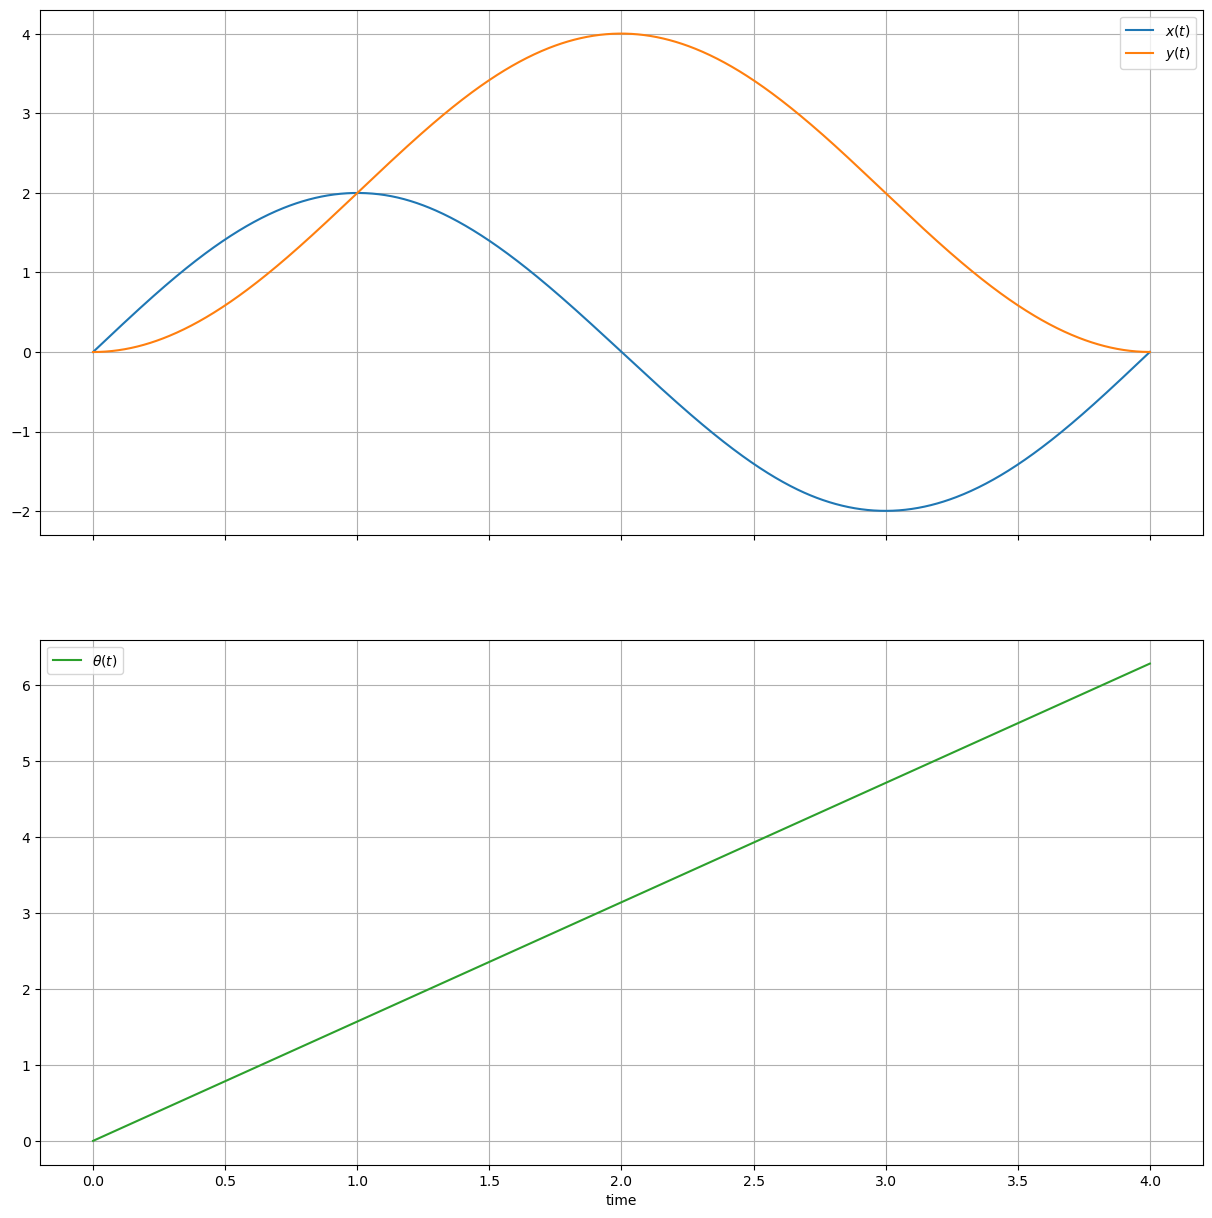

In [9]:
# 🔓
t = linspace(0.0, 4.0, 1000)
x, y, theta = r["sol"](t)
fig=figure(figsize=(15, 15))
ax1, ax2 = fig.subplots(2, 1, sharex=True)
ax1.grid(True)
ax1.plot(t, x, label="$x(t)$")
ax1.plot(t, y, label="$y(t)$")
ax1.legend()
ax2.grid(True)
ax2.plot(t, theta, label=r"$\theta(t)$", color="C2")
ax2.legend()
xlabel("time")
pass

🧩 Use the simulation results to display the robot location every 0.5 second.

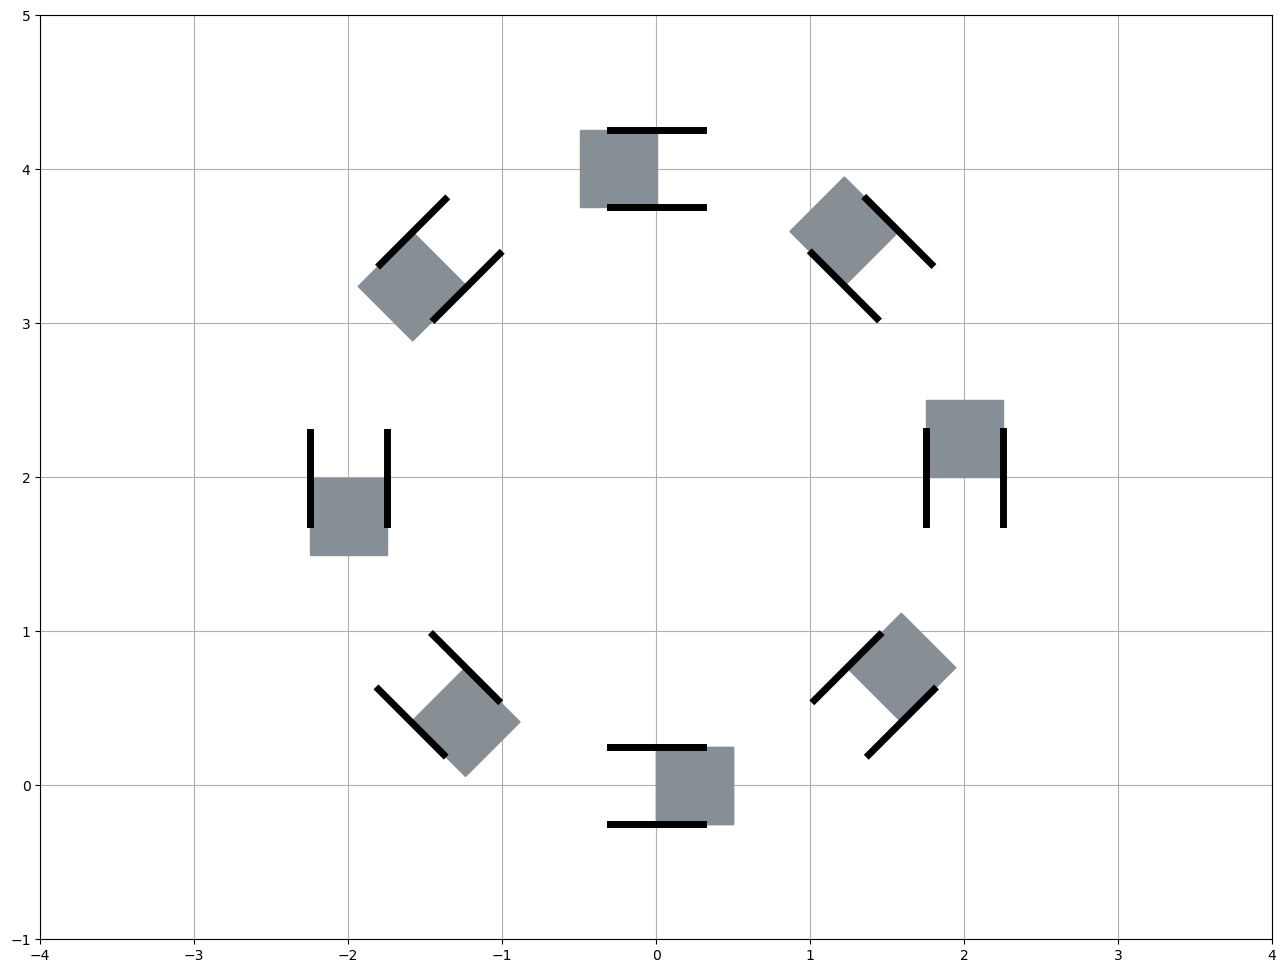

In [10]:
# 🔓
t = linspace(0.0, 4.0, 4*2+1)
sol_t = r["sol"](t)
draw_arena(-4, 4, -1, 5)
for x, y, theta in sol_t.T:
    draw_wheelchair(x, y, theta)

🧩 What should be the analytical expression of $x(t)$, $y(t)$ and $\theta(t)$? 

$\theta(t) = 2 \pi / 4.0$, $x(t) = 2\sin(2\pi t / 4)$ and $y(t) = -2 \cos(2\pi t / 4)+2$.

🧩 Do you experimental results match the theoretical results ? Draw the curves of the simulation error at time $t$ for $x$, $y$ and $\theta$.

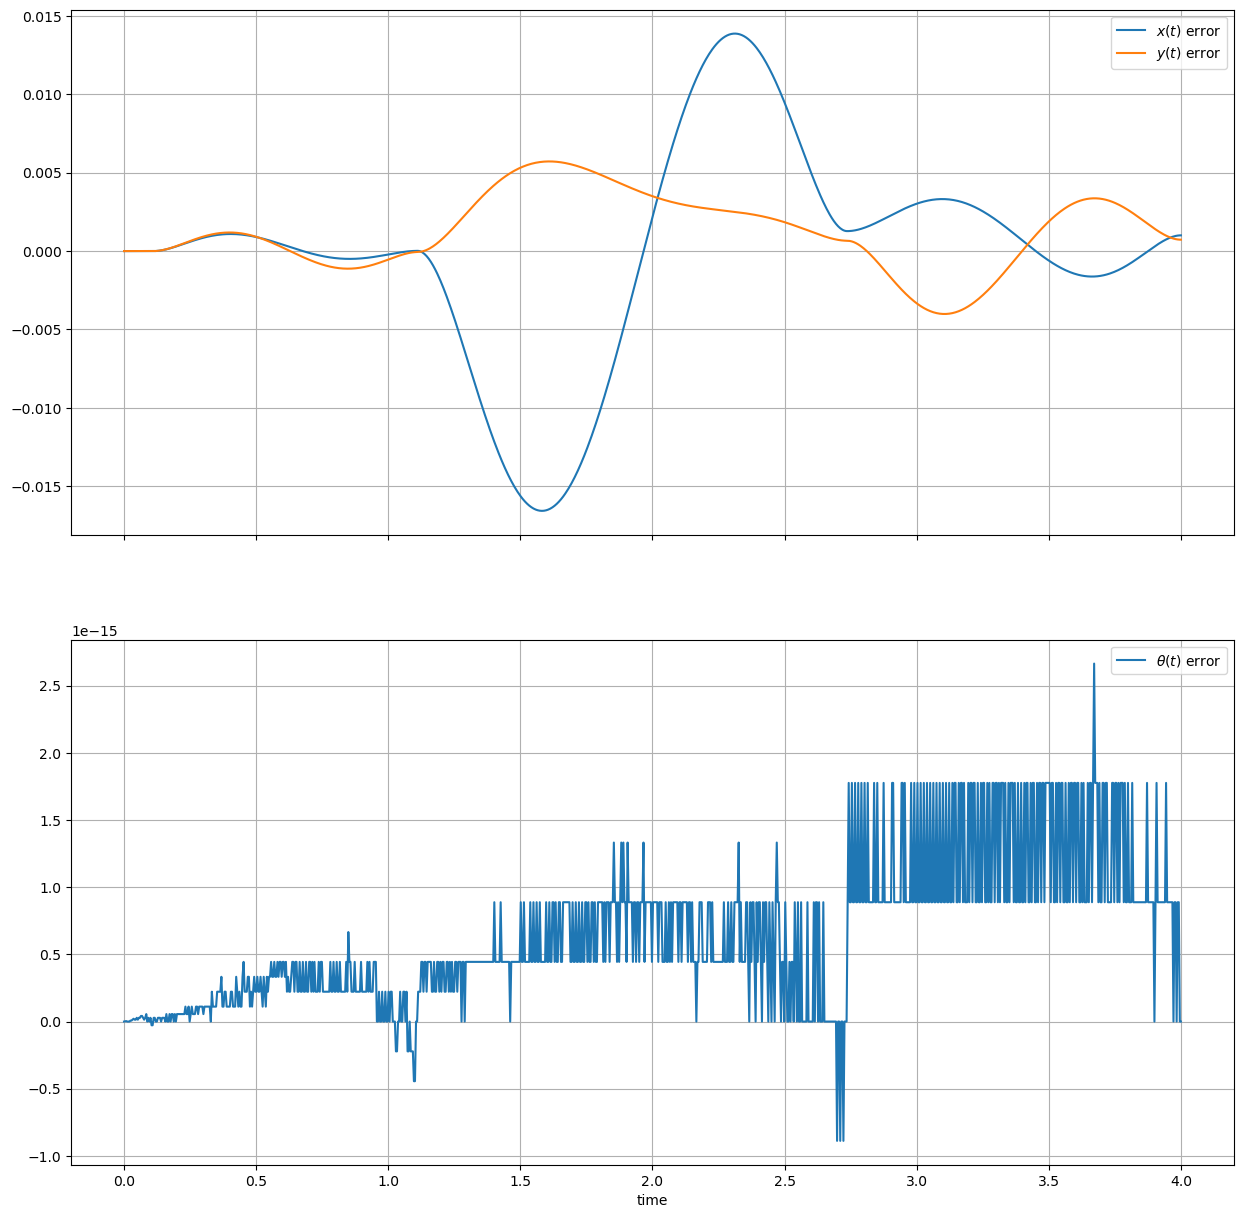

In [11]:
t = linspace(0.0, 4.0, 1000)
x_t, y_t, theta_t = r["sol"](t)
fig=figure(figsize=(15, 15))
ax1, ax2 = fig.subplots(2, 1, sharex=True)
ax1.grid(True)
ax1.plot(t , x_t - 2*sin(2*pi*t/4), label="$x(t)$ error")
ax1.plot(t , y_t + 2*cos(2*pi*t/4) - 2, label="$y(t)$ error")
ax1.legend()
ax2.grid(True)
ax2.plot(t, theta_t - 2*pi*t / 4.0, label=r"$\theta(t)$ error")
ax2.legend()
xlabel("time")
pass

🧩 If needed, adjust the simulation parameters until this error is uniformly less than $2 \times 10^{-5}$ for every component of $(x, y, \theta)$.

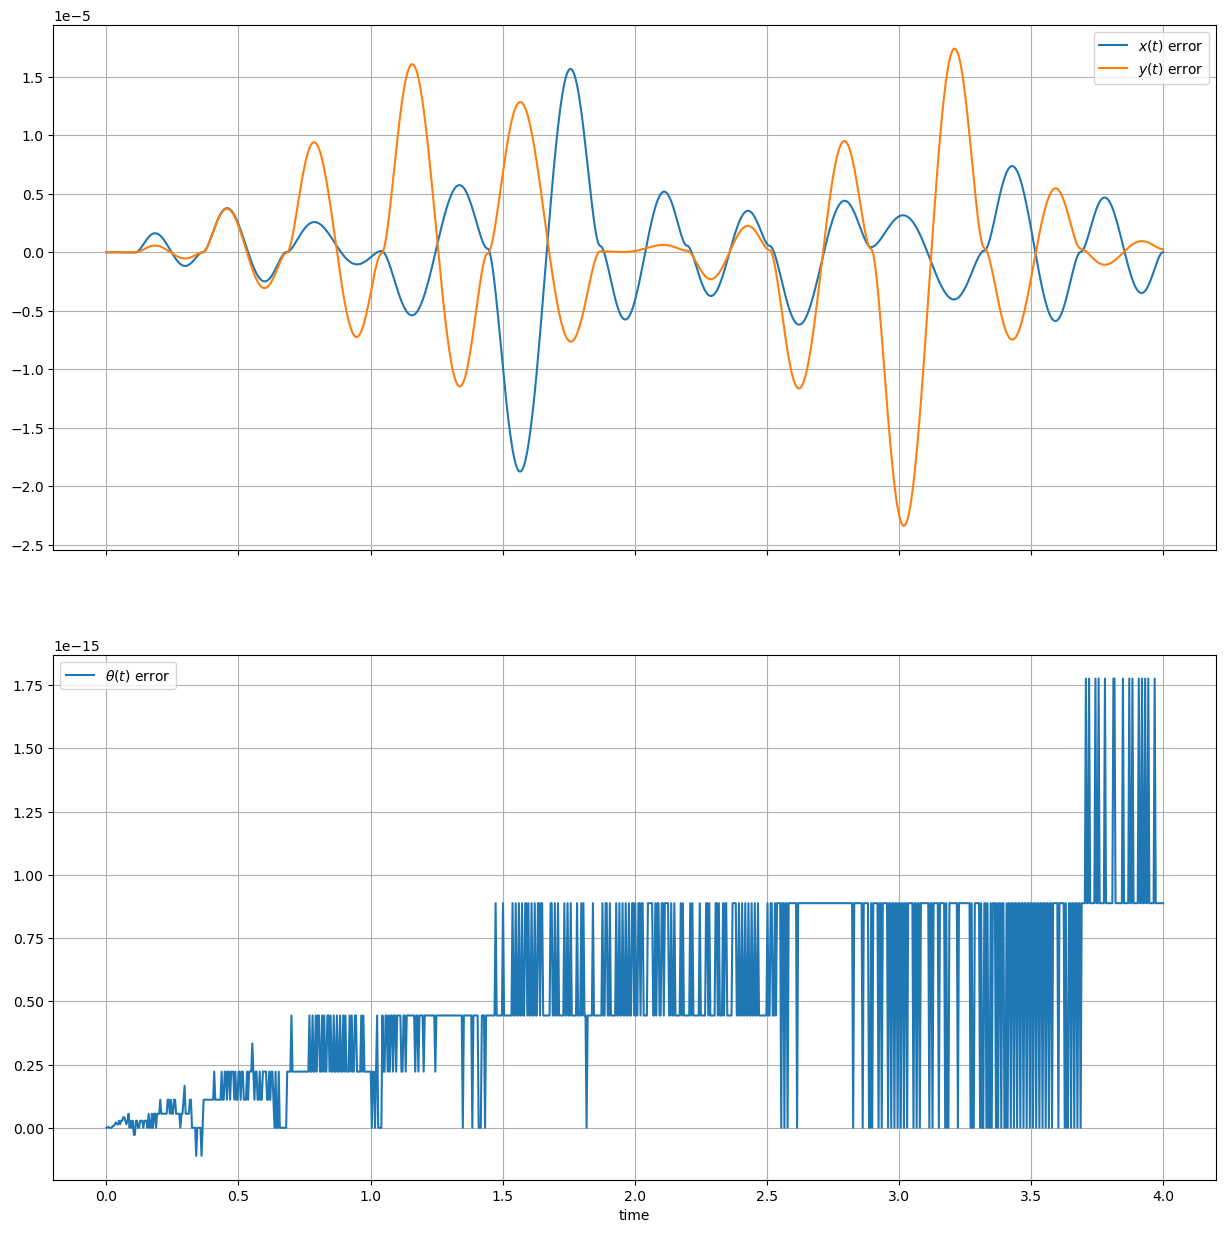

In [12]:
r = solve_ivp(
    fun=fun, 
    t_span=(0.0, 4.0), 
    y0=[0.0, 0.0, 0.0], 
    rtol=1e-6, 
    atol=1e-12, 
    dense_output=True
)
t = linspace(0.0, 4.0, 1000)
x_t, y_t, theta_t = r["sol"](t)
fig=figure(figsize=(15, 15))
ax1, ax2 = fig.subplots(2, 1, sharex=True)
ax1.grid(True)
ax1.plot(t , x_t - 2*sin(2*pi*t/4), label="$x(t)$ error")
ax1.plot(t , y_t + 2*cos(2*pi*t/4) - 2, label="$y(t)$ error")
ax1.legend()
ax2.grid(True)
ax2.plot(t, theta_t - 2*pi*t / 4.0, label=r"$\theta(t)$ error")
ax2.legend()
xlabel("time")
pass

Step 2 - Control Implementation
===============================

Time dependent inputs
---------------------

We are going to simulate the case of the chariot controlled by time-dependent angular velocities $\omega_l$ and $\omega_r$. 
We want a simulation lasting 5 seconds with the following inputs:
$$
    \omega_l(t) = \left\{
       \begin{array}{rl}
           (1 - L/4) \pi / R_w & \mbox{when $t \leq 1s$ or $t \geq 3$,} \\
           (1 + L/4) \pi / R_w & \mbox{otherwise.}
       \end{array}
    \right.
$$
and
$$
    \omega_r(t) = \left\{
       \begin{array}{rl}
           (1 + L/4) \pi / R_w & \mbox{when $t \leq 1s$ or $t \geq 3$,} \\
           (1 - L/4) \pi / R_w & \mbox{otherwise.}
       \end{array}
    \right.
$$

##### 🧩 Provide the new definition of `omega`

In [13]:
def omega(t, xytheta):
    if t<=1 or t>=3:
        omega_l = (1 - L/4) * pi / Rw
        omega_r = (1 + L/4) * pi / Rw
    else:
        omega_l = (1 + L/4) * pi / Rw
        omega_r = (1 - L/4) * pi / Rw
    return array([omega_l, omega_r])

##### 🧩 Make a simulation of 4s of the robot with the previous input. Use the `rtol` and `atol` that used to guarantee a precision of $2 \times 10^{-5}$ and by using the `dense_output` option to evaluate the solution at timesteps that will be defined later.

🗝️ **Hint.** It is not necessary to define again the function `fun`. If the previous cell has been correctly validated, `fun` will use the new definition of `omega`. 

In [14]:
sol1 = solve_ivp(fun, (0.0, 4.0), y0=[0.0,0.0,0.0], rtol=2e-5, atol=2e-5, dense_output=True)

Text(0.5, 0, 'time')

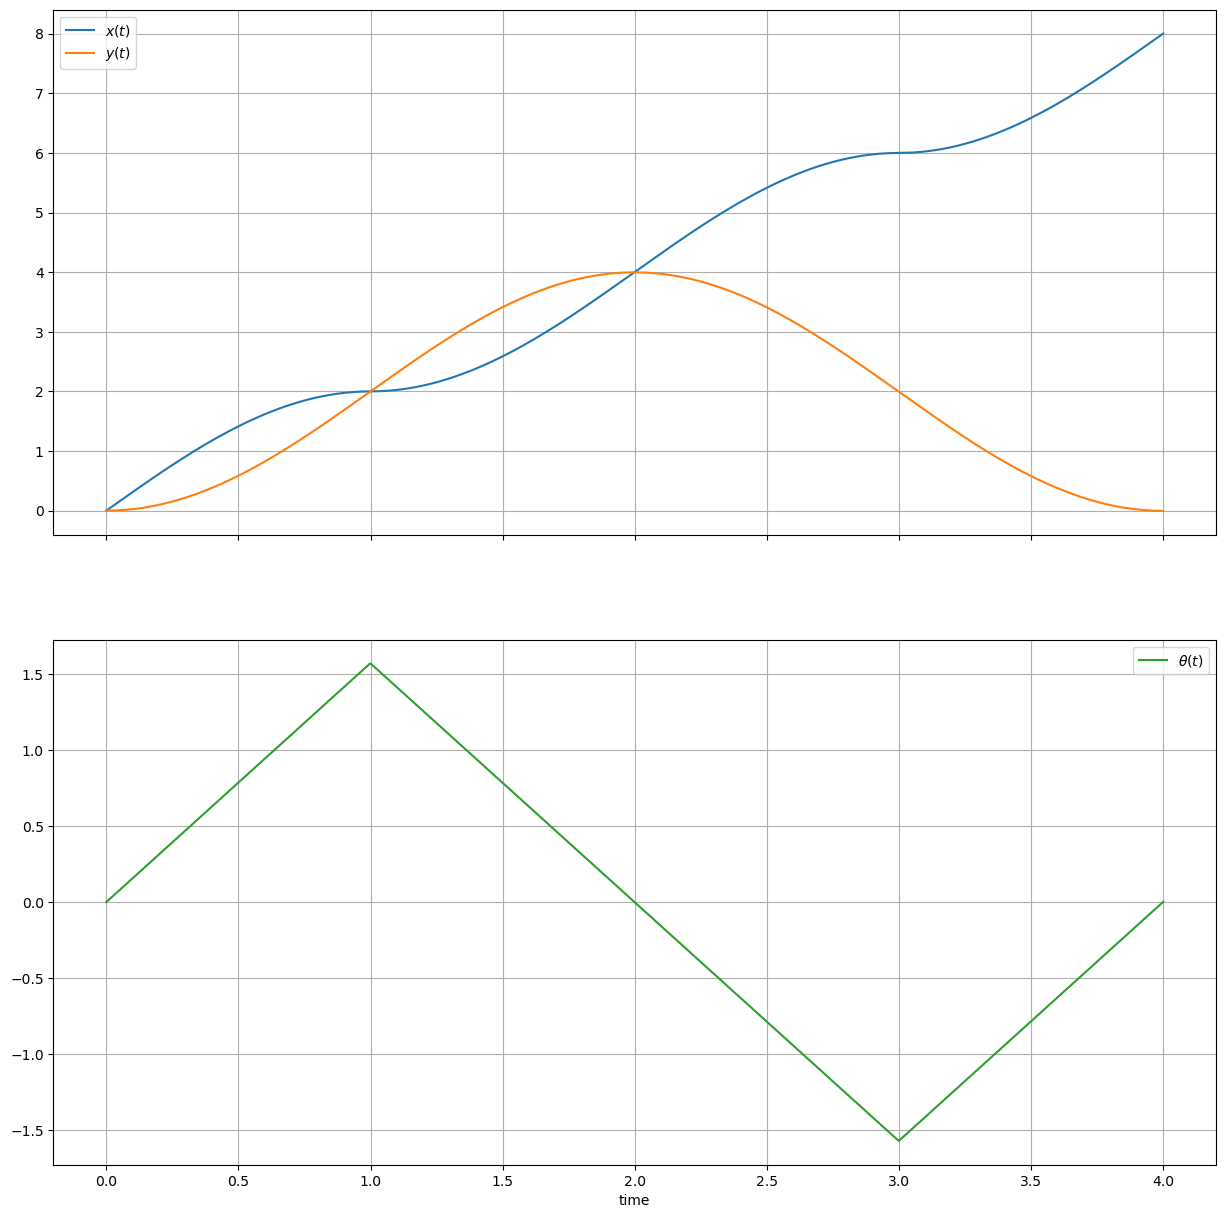

In [15]:
t = linspace(0.0, 4.0, 1000)
x, y, theta = sol1["sol"](t)
fig=figure(figsize=(15, 15))
ax1, ax2 = fig.subplots(2, 1, sharex=True)
ax1.grid(True)
ax1.plot(t, x, label="$x(t)$")
ax1.plot(t, y, label="$y(t)$")
ax1.legend()
ax2.grid(True)
ax2.plot(t, theta, label=r"$\theta(t)$", color="C2")
ax2.legend()
xlabel("time")

🧩 Use the simulation results to display the robot location every 0.5 seconds.

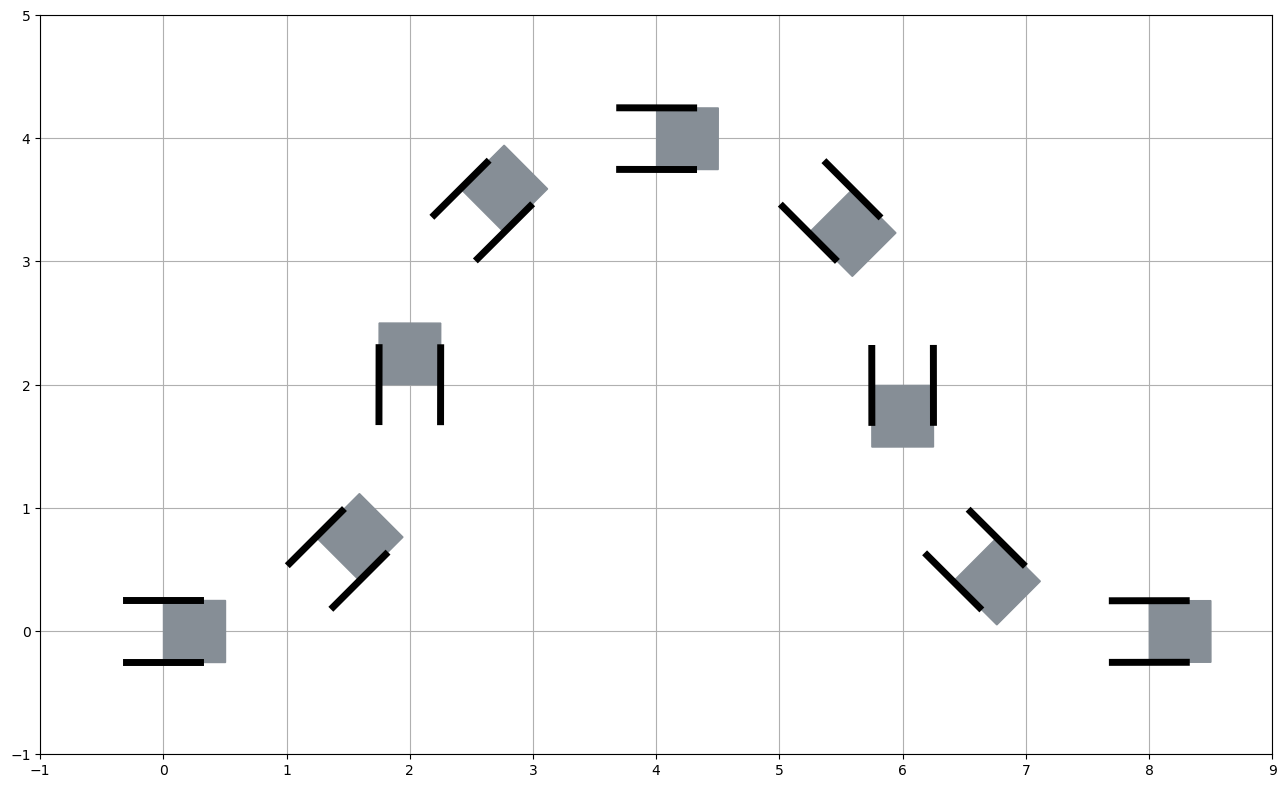

In [16]:
t = linspace(0.0, 4.0, 4*2+1)
sol_t = sol1["sol"](t)
draw_arena(-1, 9, -1,5 )
for x, y, theta in sol_t.T:
    draw_wheelchair(x, y, theta)

## Analysis of the system at rest

### Equilibrium

##### 🧩 Show that for a suitable (constant) choice $\omega_e \in \mathbb{R}^2$ of the vector input $\omega$, the state $X_e = (x_e, y_e, \theta_e) = (0,0,0)$ is an equilibrium of the wheelchair kinematic model.

**Answer:**
The state $X_e = (x_e, y_e, \theta_e) = (0, 0, 0)$ is an equilibrium if $fun(X_e) = (0, 0, 0)$. Thus,
\begin{align*}
\dot{x} &= Rw \cdot 0.5 \cdot (\omega_l + \omega_r) \cdot \cos(\theta) = 0 \\
\dot{y} &= Rw \cdot 0.5 \cdot (\omega_l + \omega_r) \cdot \sin(\theta) = 0 \\
\dot{\theta} &= \frac{Rw}{L} \cdot (\omega_r - \omega_l) = 0 \\
\end{align*}
Thus $(\omega_l + \omega_r) = 0$ and $(\omega_r - \omega_l) = 0$.\
Thus $\omega_l = \omega_r = 0$.\
Which means $\omega_e = (0, 0)$.

##### 🧩 Show that for any other $\omega_e$, the system has no equilibrium.

**Answer:**
The demonstration below is by absurd.

Suppose that $fun(X_e) = (0,0,0)$ for $\omega = \omega_e$.

Since $\theta_e = 0$, we have $\omega_r = \omega_l$.

Also, $\dot{x_e} = \dot{y_e} = 0$, thus $\cos(\theta) = \sin(\theta) = 0$, since $\omega_l + \omega_r \neq 0$, which is absurd.

Conclusion: if $\omega \neq \omega_e$, the system has no equilibrium.

##### 🧩 Conversely, if $\omega = \omega_e$, what are the other equilibria of the system?

**Answer:**
Since we have $\omega = \omega_e$, every initial state is an equilibrium state.

Mathematically, for any $x, y, \theta \in \mathbb{R}$, we have $\dot{x} = \dot{y} = \dot{\theta} = 0$ since $\omega_l = \omega_r = 0$.

And this goes with the common sense that if the wheels aren't rotating every position is an equilibrium.

### Linearized System Model


Let $\omega = \omega_e$ and $X_e = (0,0,0)$. Let us introduce the the error variable $\Delta X = (\Delta x, \Delta y, \Delta \theta) = X - X_e$ and $\Delta \omega = \omega - \omega_e$.

##### 🧩 Compute the corresponding linearized dynamics and put it in standard form: compute the matrices $A$ and $B$ (remember that $\omega = (\omega_l,\omega_r)$).

**Answer:**
A = \begin{bmatrix}
0 & 0 & 0 \\
0 & 0 & 0 \\
0 & 0 & 0 \\
\end{bmatrix}

B = \begin{bmatrix}
    R_w \cdot 0.5 \cdot \cos(\theta) & R_w \cdot 0.5 \cdot \cos(\theta) \\
    R_w \cdot 0.5 \cdot \sin(\theta) & R_w \cdot 0.5 \cdot \sin(\theta) \\
    -R_w / L & R_w / L
\end{bmatrix}

<div style="background:orange">

Simplify!    
    
</div>

### Stability of the linearized system

##### 🧩 Is the linearized system asymptotically stable around $(0,0,0)$ when $\Delta \omega = (0,0)$ ?

**Answer:** 

For any state $X_0$, let $\epsilon > 0$, and $\tau=0$.

If $\Delta\omega=(0,0)$, then $\Delta X(t) = (0,0,0)$ for any initial condition, meaning that $|\Delta X(t)|=0<\epsilon$ when $t>0$.

So the linearized system is asymptotically stable around (0,0,0).

<div style="background:orange">

No.    
    
</div>

##### 🧩 Is the original system asymptotically stable ? Or even (locally) attractive ? 

🔓 **Answer:**
In the original state we have Δ𝜔=(0,0).
Thus the only initial state, where the solution converge toward the original position, is x_0 = (0,0,0)

Then the original system is not asymptotically stable and not attractive

### Controllability of the linearized system

In this section, we consider only the linearized system defined by the matrices $A$ and $B$ computed previously:

$$
\frac{\Delta X}{dt} = A \Delta X + B\Delta u
$$

##### 🧩 Is there an admissible trajectory that start with the state $X_0=(-2,0,0)$ and ends at origin after some time?  

**Answer:**
Yes, we need just to find Δ𝑢 = (𝜔𝑙,𝜔𝑟)

We have,     $$
\frac{\Delta X}{dt} = B\Delta u
$$

the system will be: 

dx/dt = 𝑅𝑤/2 ⋅(𝜔𝑙+𝜔𝑟)

dy/dt = 0

d $\theta$ / dt = 𝑅𝑤/2 ⋅(𝜔𝑟-𝜔𝑙)

<div style="background:orange">

$$
\frac{d\theta}{dt} = \frac{R_w}{L}(\omega_r - \omega_l)
$$
    
</div>

We can choose 𝜔𝑟 = 𝜔𝑙 to go straight

Thus after integration between (0,0,0) and 𝑋0, we find 𝜔 = 2/𝑅𝑤

In conclusion, there an admissible trajectory that ends at origin starting from $X_0$ after some time.

##### 🧩 Is there an admissible trajectory that start with the state $X_0=(0,2,0)$ and ends at origin after some time?  

**Answer:**
In the system $
\frac{\Delta X}{dt} = B\Delta u
$ we find dy/dt = 0

Thus y(t) = cste = 2, so there is no admissible trajectory that ends at origin in this situation.

##### 🧩 Is the linearized system controllable?

**Answer:**
We compute the controllability matrix: C = [B, AB, A²B] = [B, 0, 0]

Since the rows are linearlly dependent, the rank of the matrix C is different than 3.

Then the system isn't controllable.(this is supported by the previous question that there no admissible trajectory that start with the state  𝑋0=(0,2,0) and ends at origin after some time)

## Control on a straight line

### Admissible trajectories

Let $x_R(t) = v t$ and $y_R(t) = 0$ where $v \in \mathbb{R}$ and $v \neq 0$. 

##### 🧩 Determine the set of trajectories $X_R(t) = (x_R(t), y_R(t), \theta_R(t))$ which are admissible and compute the corresponding reference control $\omega_{R}(t)$.

**Answer:**
$X_R(t) = (x_R(t), y_R(t), \theta_R(t))$ which are admissible and compute the corresponding reference control $\omega_{R}(t)$.

we have $\dot{y_R(t)}=0$, so either $\sin{\theta}=0$ or $w_{l}+w_{r}=0$, but if $w_{l}+w_{r}=0$ , then $\dot{x_R(t)}=v=0$ which is absurd.

Thus, $\sin{\theta}=0$, thus $\theta=k\pi$ and $\dot{\theta}=0$, but then $w_{l}=w_{r}$, so $w_{l}=w_{r}=\frac{v}{R_{w}\cos{k\pi}}$

the admissible trajectories are then $X_{R}(t)=(vt,0,k\pi)$ with $\omega_{R}(t)=(\frac{v}{R_{w}\cos{k\pi}},\frac{v}{R_{w}\cos{k\pi}})$


### Linearized system

Let $\Delta X(t) = X(t) - X_R(t)$ and $\Delta \omega(t) = \omega(t) - \omega_R(t)$.

##### 🧩 Compute the linearized dynamics of the system for the class of trajectory "moving forward".

**Answer:**
A = \begin{bmatrix}
0 & 0 & 0 \\
0 & 0 & v \\
0 & 0 & 0 \\
\end{bmatrix} \
B = \begin{bmatrix}
R_w \cdot 0.5 & R_w \cdot 0.5 \\
0 & 0 \\
-\frac{R_w}{L} & \frac{R_w}{L}\\
\end{bmatrix} 

in fact
$$ A = \frac{\partial fun}{\partial X}(X_R(t))\\
B = \frac{\partial fun}{\partial w}(X_R(t)) $$

##### 🧩 Is the system asymptotically stable, with $\Delta\omega(t)=0$?

**Answer:**
Since Δ𝜔(𝑡)=0, $$
\frac{\Delta X}{dt} = A \Delta X
$$

And the eigenvalues of A are equal to zero.(not negative)

Then the system isn't asymptotically stable.

##### 🧩 Is the system attractive, with $\Delta\omega(t)=0$?

**Answer:**
Still $$
\frac{\Delta y}{dt} = 0
$$ , which means that if the wheelchair deviates from its starting point (the origin) then the system can't go back to it.

Thus the system isn't attractive.

##### 🧩 Show that the linearized system is controllable.

**Answer:**
We compute the controllability matrix: C = [B, AB, A²B]

we find, $C=\begin{bmatrix}
R_w/2 & R_w/2 & 0 & 0\\
0 & 0 & -v*R_w/L & 0\\
-R_w/L & R_w/L & 0 & 0\\
\end{bmatrix}$ 

the rows are linearlly idependent, so the all rank equal 3.

Thus the linearized system is controllable.

### Linearized system implementation

In the sequel, we will use $v=4.8 \mbox{ km/h}$.

##### 🧩 Implement and print the matrices $A$ and $B$

In [17]:
A=np.array([[0,0,0],[0,0,4.8/3.6],[0,0,0]])
B=np.array([[Rw*0.5,Rw*0.5],[0,0],[-Rw/L,Rw/L]])
print("A = ",A)
print("B = ",B)

A =  [[0.         0.         0.        ]
 [0.         0.         1.33333333]
 [0.         0.         0.        ]]
B =  [[ 0.15  0.15]
 [ 0.    0.  ]
 [-0.6   0.6 ]]


The linear model has to be fed with some $\Delta\omega$ input. Like for the nonlinear system, we define a function $\Delta\omega(t,\Delta_X)$ that computes the input of the linearized system. For example, if we do not want any correction to the reference input, we set:

In [18]:
def deltaOmega(t, deltaX):
    return array([0, 0])

##### 🧩 Using this function `deltaOmega`, define a function `lin_fun` that computes $d{\Delta X}/dt$ given the arguments `t` and `deltaX`$.

In [19]:
def lin_fun(t, deltaX):
    deltaXdt=np.dot(A,deltaX)
    deltawdt=np.dot(B,deltaOmega(t,deltaX))
    return deltaXdt+deltawdt

### Controller Design on the linearized system

##### 🧩 Implement a process that computes a gain matrix $K$ that places the poles of the linearized system at some arbitrary location. 

For this question, we will chose 3 real poles close to -0.5.

Then, print the poles of the closed-loop system

$$
\frac{d\Delta X}{dt}= A \Delta X + B\Delta\omega
\; \mbox{ with } \;
\Delta\omega = -K \Delta X.
$$

In [20]:
poles = np.array([-0.49, -0.51, -0.52])

# Compute gain matrix
K = place_poles(A, B, poles).gain_matrix
print(K)
Eigenvalues = eigvals(A - B@K)
print("Poles:", real(Eigenvalues))

[[ 1.69999995 -0.15823646 -0.83904242]
 [ 1.70000004  0.16026354  0.84429092]]
Poles: [-0.51 -0.52 -0.49]


##### 🧩 Simulate the linearized system during 20s, with the initial condition $\Delta X(0) = (0,2,0)$.

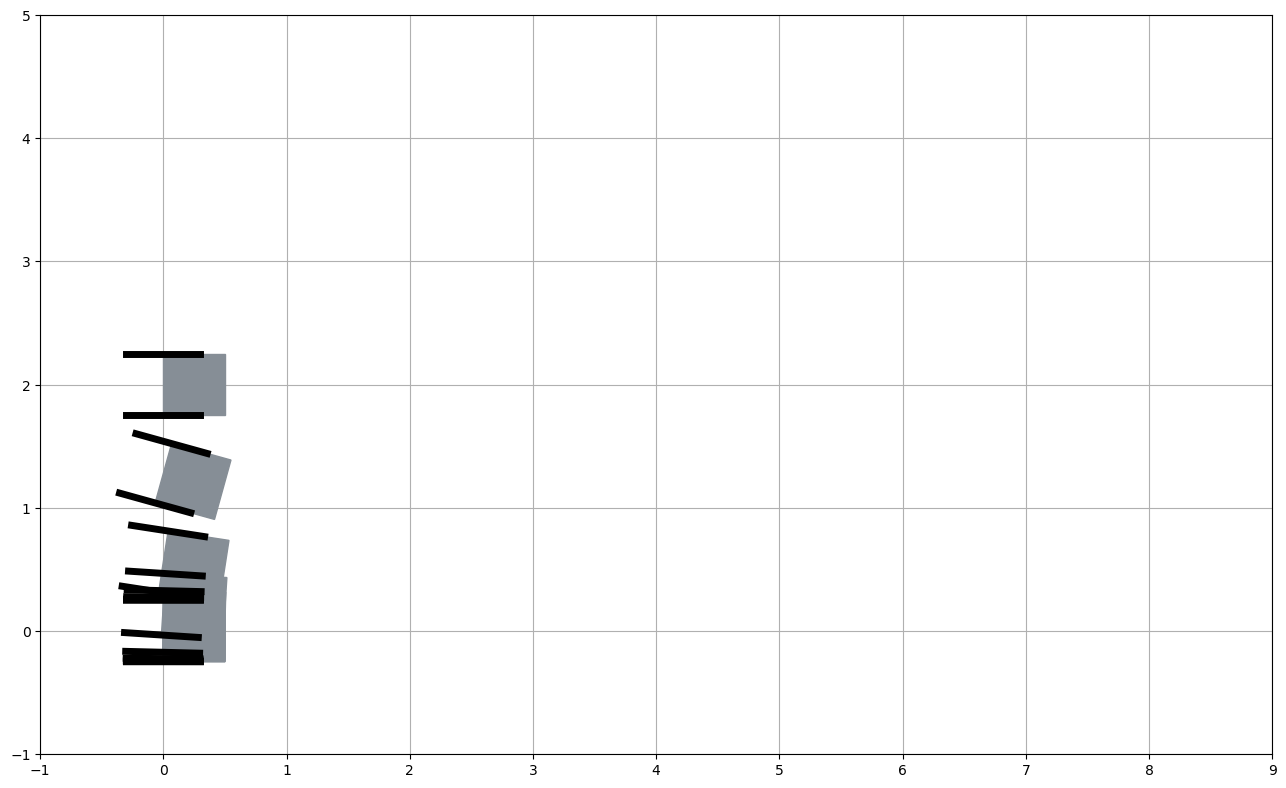

In [21]:
def deltaOmega(t, deltaX):
    return -K@deltaX
sol2 = solve_ivp(lin_fun, (0.0, 20.0), y0=[0.0,2.0,0.0], rtol=2e-5, atol=2e-5, dense_output=True)

t = linspace(0.0, 20.0, 4*2+1)
sol_t = sol2["sol"](t)
draw_arena(-1, 9, -1,5 )
for x, y, theta in sol_t.T:
    draw_wheelchair(x, y, theta)

<div style="background:orange">
    
Remember that the content of `sol_t` here is $\Delta x$, $\Delta y$ and $\Delta \theta$, so `draw_wheelchair` shouldn't be used directly on these variables.    
    
</div>

🧩 Plot the values of $\Delta x(t)$, $\Delta y(t)$ and $\Delta\theta(t)$ (**plot $\Delta\theta(t)$ in degrees**)

Text(0.5, 0, 'time')

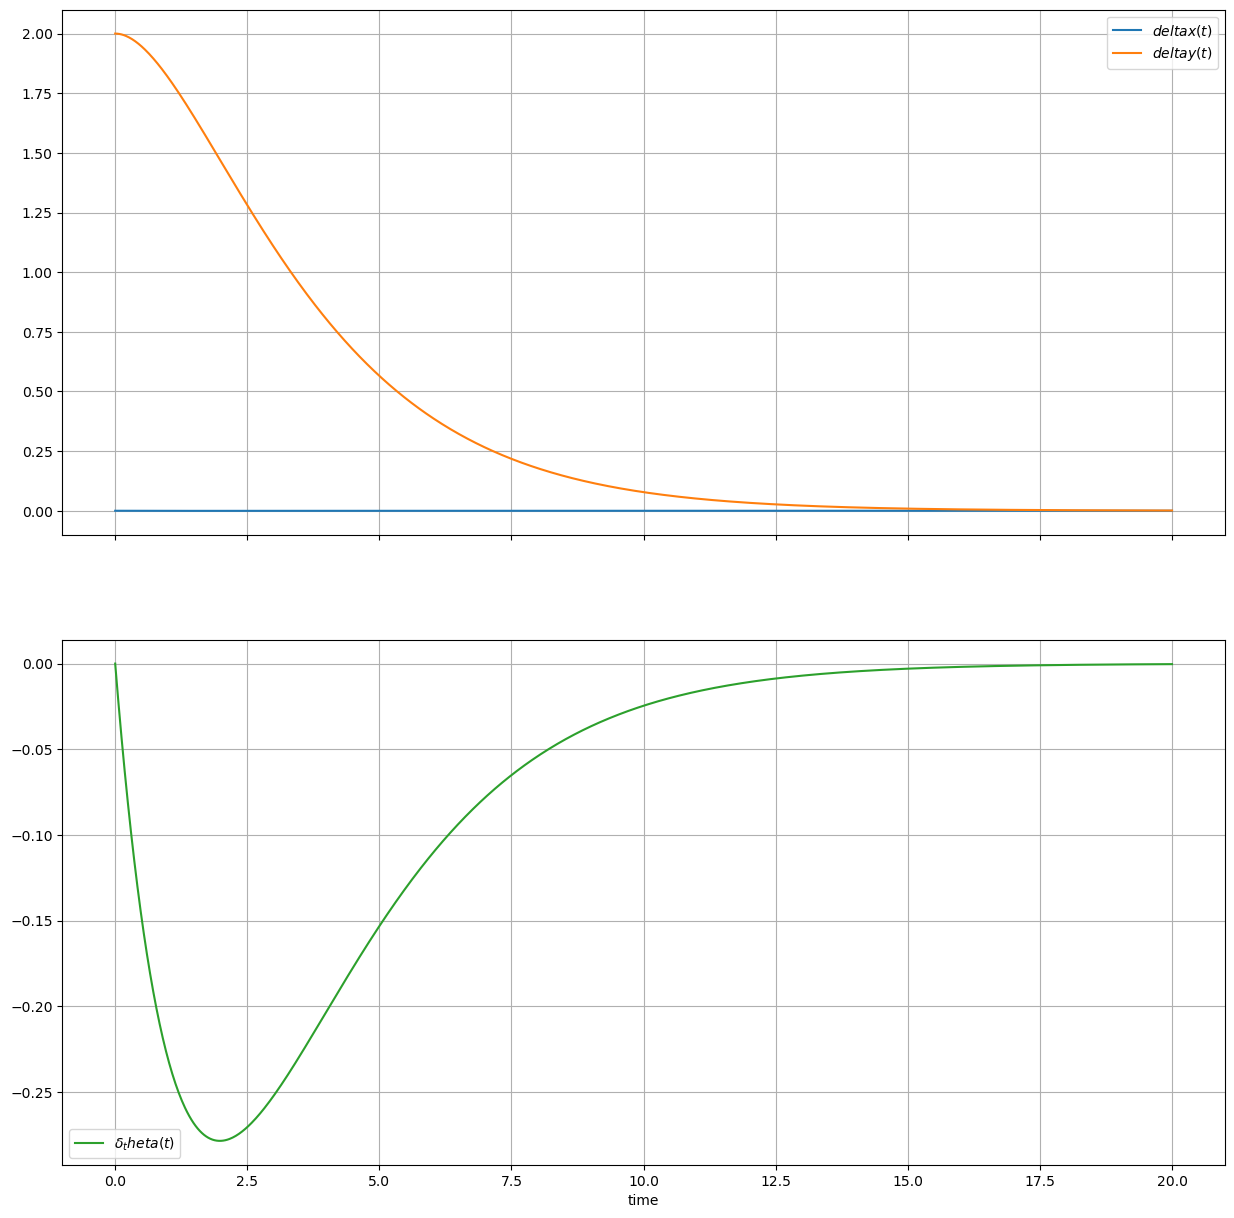

In [22]:
t = linspace(0.0, 20.0, 1000)
x, y, theta = sol2["sol"](t)
fig=figure(figsize=(15, 15))
ax1, ax2 = fig.subplots(2, 1, sharex=True)
ax1.grid(True)
ax1.plot(t, x, label="$deltax(t)$")
ax1.plot(t, y, label="$deltay(t)$")
ax1.legend()
ax2.grid(True)
ax2.plot(t, theta, label=r"$\delta_theta(t)$", color="C2")
ax2.legend()
xlabel("time")

##### 🧩 Why is it important to check that $\Delta\theta(t)$ stays small ?

**Answer:**
To guarantee the linearization of the system Δ𝜃(𝑡) must be small

##### 🧩 Compute the corresponding values of $\Delta\omega_l,\Delta\omega_r$ and store them in the Python variables `dOmega_l`, `dOmega_r`

In [23]:
dX = sol2["sol"](t)
dOmega = -K@dX
dOmega_l = dOmega[0]
dOmega_r = dOmega[1]

##### 🧩 Compute $\omega_l,\omega_r$ and plot the translation speed of each wheels in km/h

<div style="background:orange">
    
The 4.8 km/h velocity below should be converted to m/s.
    
</div>

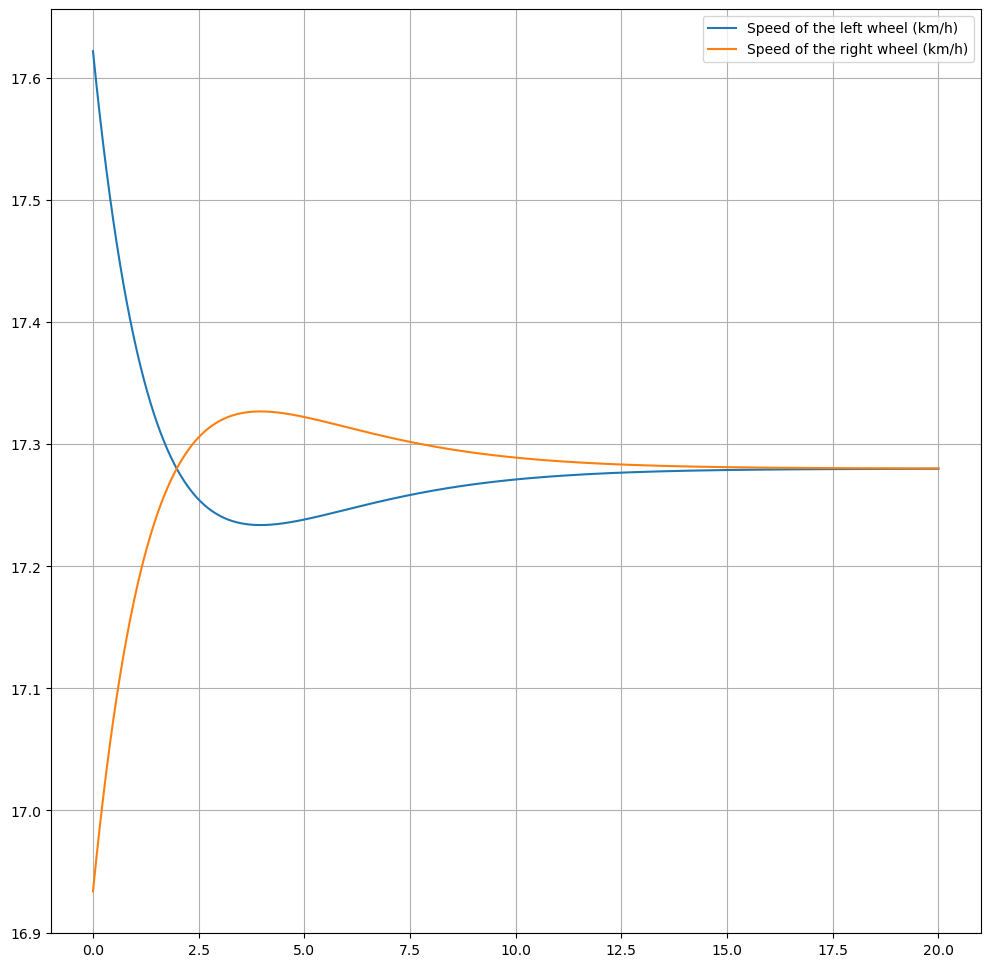

In [ ]:
Omega_l = dOmega_l + 4.8/Rw
Omega_r = dOmega_r + 4.8/Rw

fig=figure(figsize=(12, 12))
plot(t,Omega_l*Rw*3.6, label=r"Speed of the left wheel (km/h)")
plot(t,Omega_r*Rw*3.6, label=r"Speed of the right wheel (km/h)")
grid()
legend()

##### 🧩 Are these control values consistent with what the robot should do to cancel the error?

**Answer:**


###  Controller Tuning



##### 🧩 Tune the poles (and recompute the gain matrix) so that the actual location $(x, y)$ is within 10 cm of the desired location within 20 sec and the linear velocity of each wheel never exceeds $5$ km/h. Plot the values of $\Delta x$ (in m), $\Delta y$ (in m), $\Delta \theta$ (in degrees), and the speed of each wheel (in km/h)

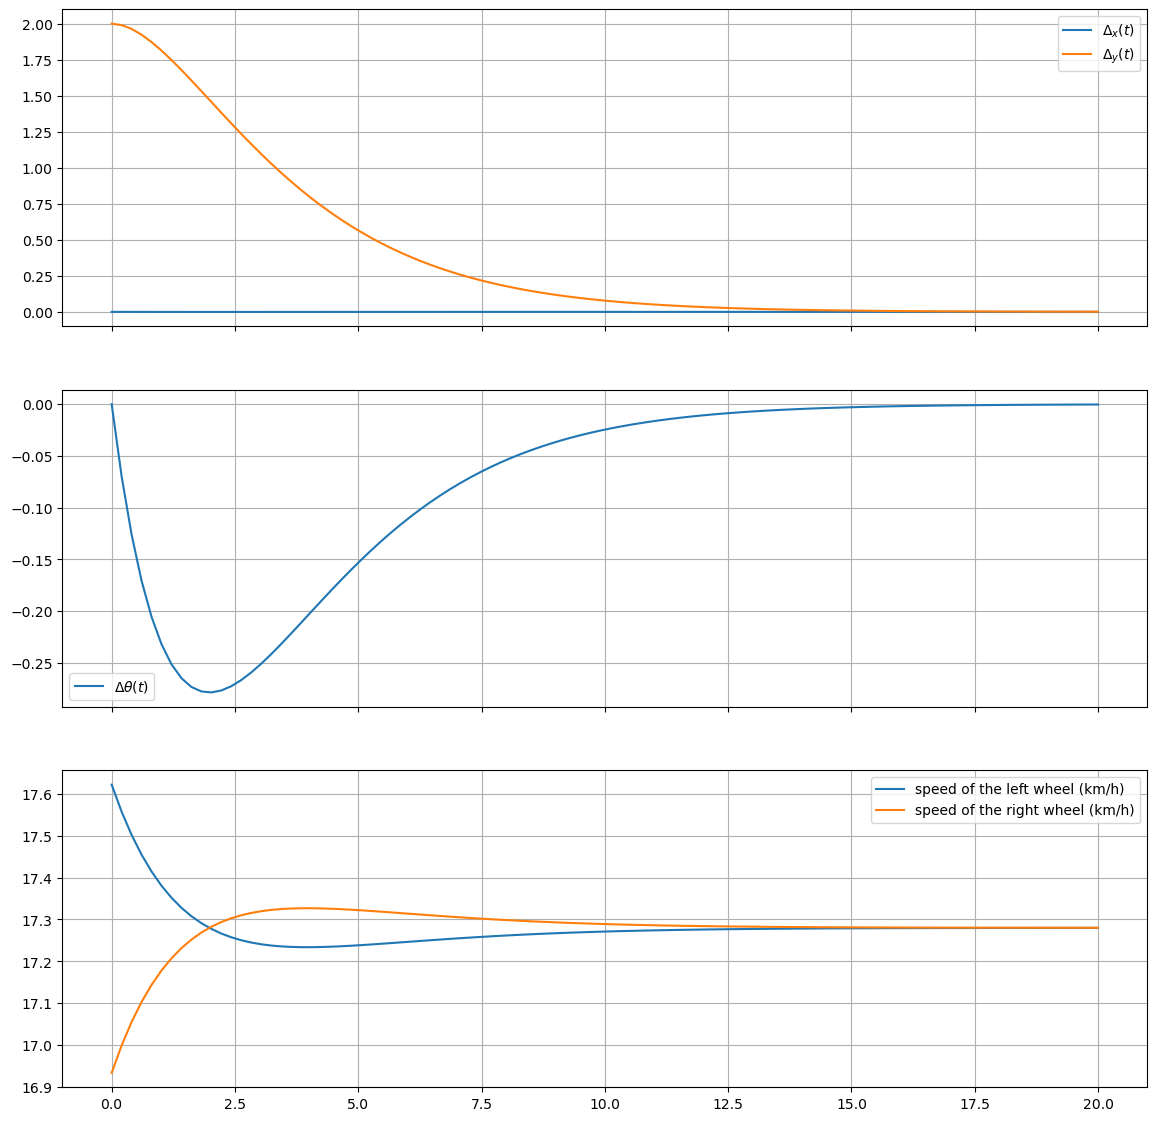

In [25]:
pole = [-0.34,-0.36,-0.4]

K = place_poles(A,B,poles).gain_matrix

T = 20
sol3 = solve_ivp(lin_fun, (0,T), y0 = [0,2,0], dense_output=True, rtol = 2e-5, atol = 2e-5)

t = linspace(0.0,T, 100)
x, y, theta = sol2["sol"](t)
fig = figure(figsize=(14, 14))
ax1, ax2, ax3 = fig.subplots(3, 1, sharex=True)
ax1.grid(True)
ax1.plot(t, x, label="$\Delta_x(t)$")
ax1.plot(t, y, label="$\Delta_y(t)$")
ax1.legend()
ax2.grid(True)
ax2.plot(t, theta, label=r"$\Delta\theta(t)$")
ax2.legend()

dX = sol3["sol"](t)
dOmega = -K@dX
dOmega_l = dOmega[0]
dOmega_r = dOmega[1]
omega_l = dOmega_l + 4.8/Rw
omega_r = dOmega_r + 4.8/Rw

ax3.plot(t,omega_l*Rw*3.6, label=r"speed of the left wheel (km/h)")
ax3.plot(t,omega_r*Rw*3.6, label=r"speed of the right wheel (km/h)")
ax3.legend()
ax3.grid()

##### 🧩 Simulate the initial, nonlinear wheelchair model when the control law computed in the section "Controller Tuning" is applied. Check that the constraint given for the control law design still hold.

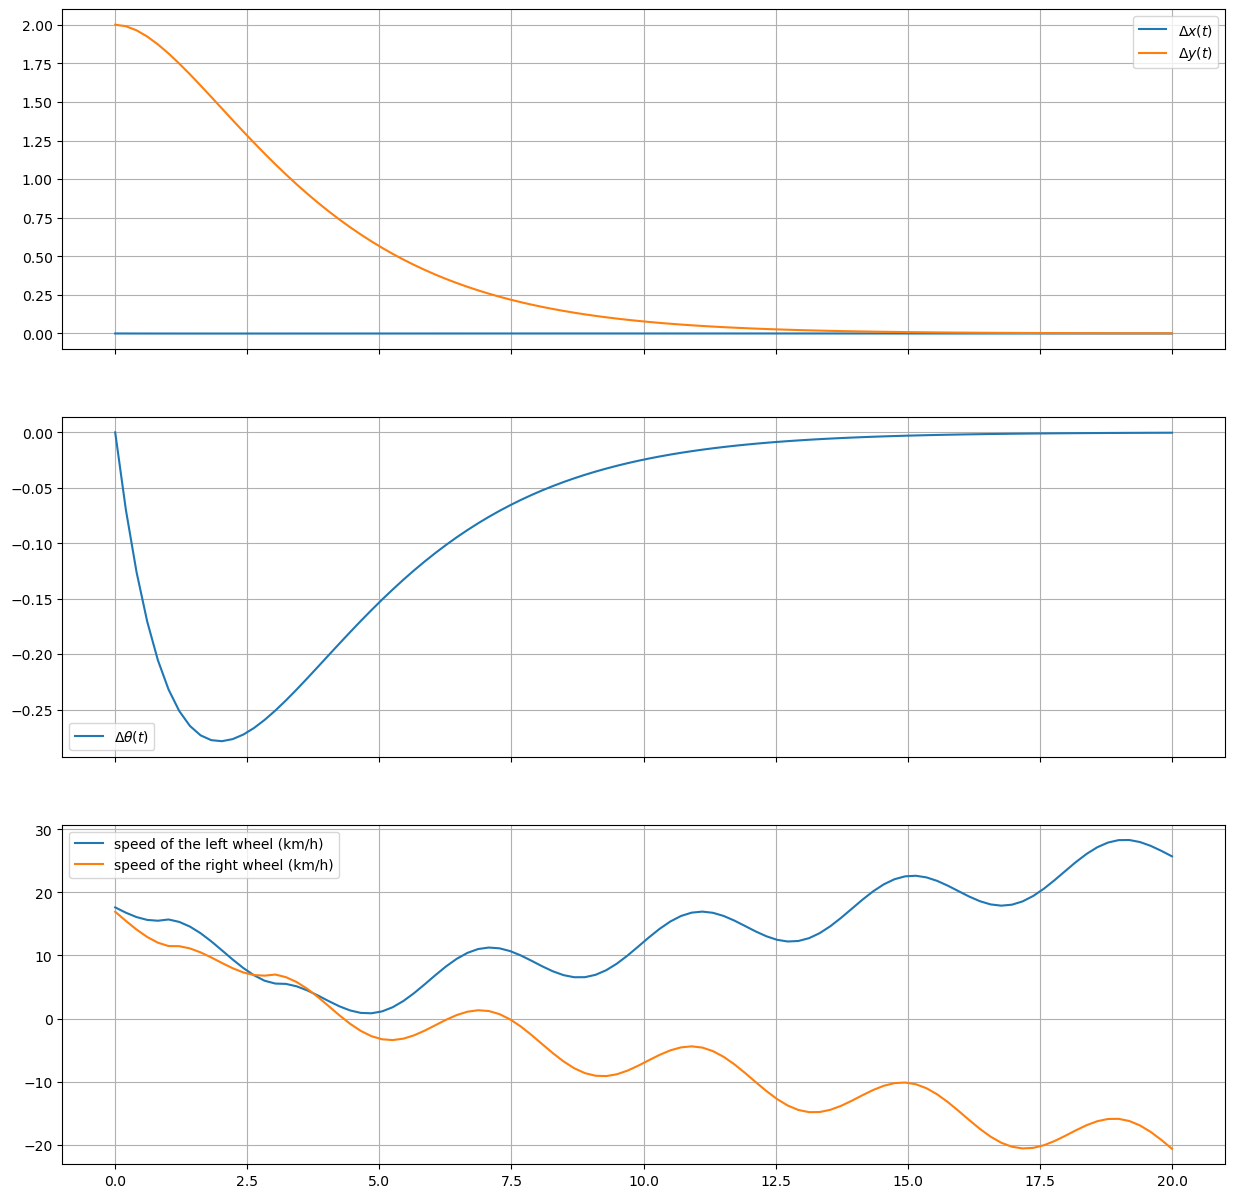

In [26]:
pole = [-0.34,-0.36,-0.4] 

K = place_poles(A,B,poles).gain_matrix

sol4 = solve_ivp(fun, (0,20), y0=[0,2,0], dense_output=True, rtol=2e-5, atol=2e-5)

t = linspace(0.0, 20, 100)
x, y, theta = sol3["sol"](t)

fig = figure(figsize=(15, 15))
axe1, axe2, axe3 = fig.subplots(3, 1, sharex=True)
axe1.grid(True)
axe1.plot(t, x, label="$\Delta x(t)$")
axe1.plot(t, y, label="$\Delta y(t)$")
axe1.legend()
axe2.grid(True)
axe2.plot(t, theta, label=r"$\Delta\theta(t)$")
axe2.legend()

dX = sol4["sol"](t)
dOmega = -K@dX
dOmega_l = dOmega[0]
dOmega_r = dOmega[1]
omega_l = dOmega_l + 4.8/Rw
omega_r = dOmega_r + 4.8/Rw

axe3.plot(t,omega_l*Rw*3.6, label=r"speed of the left wheel (km/h)")
axe3.plot(t,omega_r*Rw*3.6, label=r"speed of the right wheel (km/h)")
axe3.legend()
axe3.grid()

##### 🧩 Display this trajectory using a snapshot of the wheelchair in the plane every second.

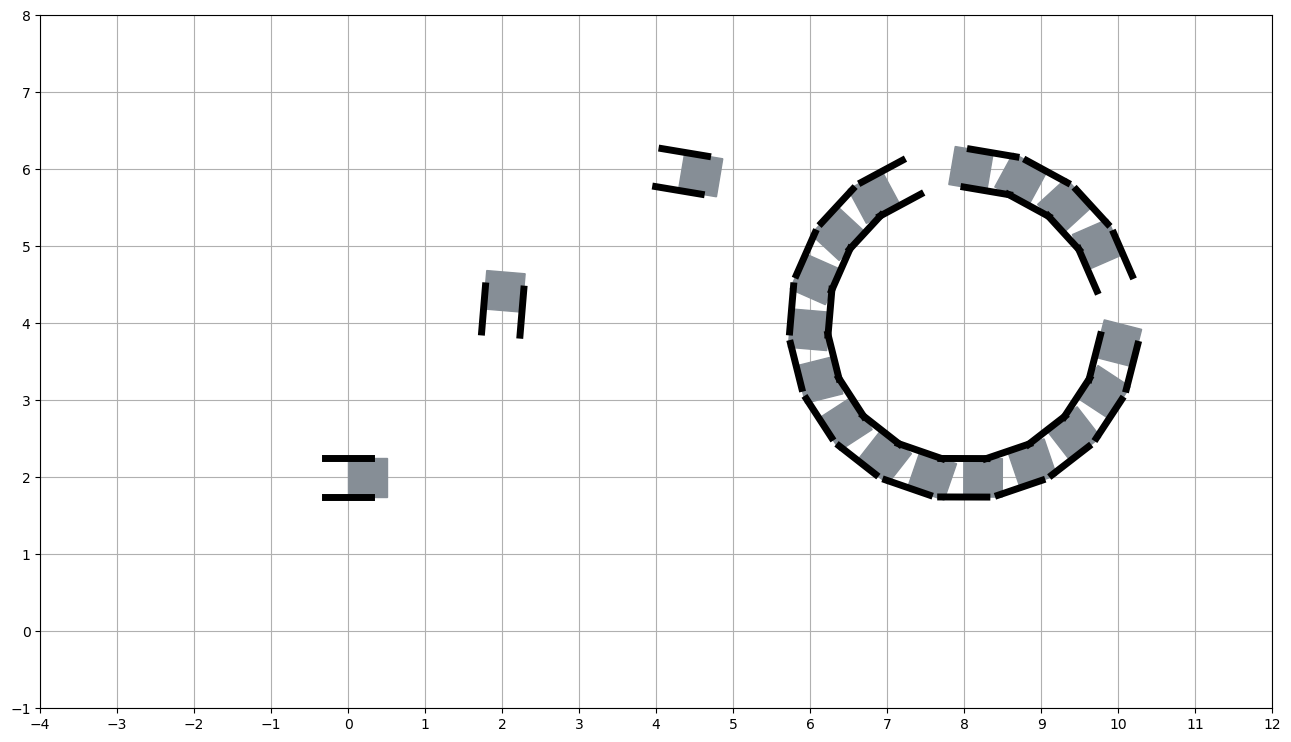

In [27]:
sol5 = solve_ivp(fun, (0,20), y0=[0.0,2.0,0.0], dense_output=True, rtol=2e-5, atol=2e-5)

draw_arena(-4, 12, -1, 8)

t = linspace(0.0, 20, 20)

Sol = sol4["sol"](t)
for x, y, theta in Sol.T:
    draw_wheelchair(x, y, theta)